Pattern Recognition Image Classification Convolutional Neural Network.

In [ ]:
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch.utils.data import random_split

Helper Functions for enabling GPU accelerated training.

In [ ]:
def get_default_device():
    """ Set Device to GPU or CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    "Move data to the device"
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking = True)

class DeviceDataLoader():
    """ Wrap a dataloader to move data to a device """

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """ Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b,self.device)

    def __len__(self):
        """ Number of batches """
        return len(self.dl)

In [ ]:
# X_train = torch.from_numpy(
#     np.genfromtxt("sample_data/mnist_train_small.csv", delimiter=",")
# )
# test = torch.from_numpy(
#     np.genfromtxt("sample_data/mnist_test.csv", delimiter=",")
# )

In [ ]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                              torchvision.transforms.Normalize((0.5,), (0.5,)),
                              ])
trainset = torchvision.datasets.MNIST('PATH_TO_STORE_TRAINSET', download=True, train=True, transform=transform)
valset = torchvision.datasets.MNIST('PATH_TO_STORE_TESTSET', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=100, shuffle=True)

'''
  src: https://towardsdatascience.com/handwritten-digit-mnist-pytorch-977b5338e627
'''

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting PATH_TO_STORE_TRAINSET/MNIST/raw/train-images-idx3-ubyte.gz to PATH_TO_STORE_TRAINSET/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting PATH_TO_STORE_TRAINSET/MNIST/raw/train-labels-idx1-ubyte.gz to PATH_TO_STORE_TRAINSET/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting PATH_TO_STORE_TRAINSET/MNIST/raw/t10k-images-idx3-ubyte.gz to PATH_TO_STORE_TRAINSET/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting PATH_TO_STORE_TRAINSET/MNIST/raw/t10k-labels-idx1-ubyte.gz to PATH_TO_STORE_TRAINSET/MNIST/raw



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting PATH_TO_STORE_TESTSET/MNIST/raw/train-images-idx3-ubyte.gz to PATH_TO_STORE_TESTSET/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting PATH_TO_STORE_TESTSET/MNIST/raw/train-labels-idx1-ubyte.gz to PATH_TO_STORE_TESTSET/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting PATH_TO_STORE_TESTSET/MNIST/raw/t10k-images-idx3-ubyte.gz to PATH_TO_STORE_TESTSET/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting PATH_TO_STORE_TESTSET/MNIST/raw/t10k-labels-idx1-ubyte.gz to PATH_TO_STORE_TESTSET/MNIST/raw



'\n  src: https://towardsdatascience.com/handwritten-digit-mnist-pytorch-977b5338e627\n'

In [ ]:
loaders = {
    'train' : trainloader,

    'test'  : valloader
}

In [ ]:
class cnn(nn.Module):
  def __init__(self):
    super(cnn, self).__init__()

    self.conv1 = nn.Conv2d(
        in_channels=1,
        out_channels=16,
        kernel_size=4)

    self.conv2 = nn.Conv2d(
        in_channels=16,
        out_channels=32,
        kernel_size=4)

    self.lin1 = nn.Linear(512, 256)
    # output to 10 classes
    self.lin2 = nn.Linear(256,10)

  def forward(self,x):
    x = F.relu(F.max_pool2d(self.conv1(x),2))
    x = F.relu(F.max_pool2d(self.conv2(x),2))
    x = x.view(x.size(0), -1)
    x = F.relu(self.lin1(x))
    x = self.lin2(x)
    return x

In [ ]:
cnn = cnn()

In [ ]:
learning_rate = 0.0001
momentum = 0.5
n_epochs = 50

In [ ]:
loss = nn.CrossEntropyLoss()

In [ ]:
device = get_default_device()

In [ ]:
train = DeviceDataLoader(loaders['train'], device)
test = DeviceDataLoader(loaders['test'], device)
gpu_loaders = {'train':train, 'test':test}
cnn.to(device)

cnn(
  (conv1): Conv2d(1, 16, kernel_size=(4, 4), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(4, 4), stride=(1, 1))
  (lin1): Linear(in_features=512, out_features=256, bias=True)
  (lin2): Linear(in_features=256, out_features=10, bias=True)
)

In [ ]:
optimizer = optim.Adam(cnn.parameters(), lr=learning_rate)

In [ ]:
def train(n_epochs, cnn, loaders):

  cnn.train()

  # Let the training commence
  tot = len(loaders['train'])

  for epoch in range(n_epochs):
    for i, (images, labels) in enumerate(loaders['train']):
      # batch data
      x = Variable(images)
      y = Variable(labels)

      optimizer.zero_grad()

      out = cnn(x.float())

      err = loss(out.to(device), y.type(torch.LongTensor).to(device))
      err.backward()

      optimizer.step()

      if (i+1)%100 == 0:
        print(f'Epoch: {epoch + 1}/{n_epochs}, Step: {i+1}/{tot}, Err:{err.item()}') # {err.item()}
    # if (epoch+1) % 10 == 0:
    #   test()

# cnn.to(device)
train(n_epochs, cnn, gpu_loaders)
# train(n_epochs, cnn, loaders)

Epoch: 1/50, Step: 100/600, Err:1.3257423639297485
Epoch: 1/50, Step: 200/600, Err:0.5215643048286438
Epoch: 1/50, Step: 300/600, Err:0.34434545040130615
Epoch: 1/50, Step: 400/600, Err:0.2953953444957733
Epoch: 1/50, Step: 500/600, Err:0.3686964511871338
Epoch: 1/50, Step: 600/600, Err:0.18450693786144257
Epoch: 2/50, Step: 100/600, Err:0.16051137447357178
Epoch: 2/50, Step: 200/600, Err:0.11511575430631638
Epoch: 2/50, Step: 300/600, Err:0.270381361246109
Epoch: 2/50, Step: 400/600, Err:0.1267160177230835
Epoch: 2/50, Step: 500/600, Err:0.29135796427726746
Epoch: 2/50, Step: 600/600, Err:0.10677456110715866
Epoch: 3/50, Step: 100/600, Err:0.10379596054553986
Epoch: 3/50, Step: 200/600, Err:0.08420228213071823
Epoch: 3/50, Step: 300/600, Err:0.11332245171070099
Epoch: 3/50, Step: 400/600, Err:0.06513737142086029
Epoch: 3/50, Step: 500/600, Err:0.08274364471435547
Epoch: 3/50, Step: 600/600, Err:0.049815841019153595
Epoch: 4/50, Step: 100/600, Err:0.09551883488893509
Epoch: 4/50, Step:

In [ ]:
def test(demo=False):

  cnn.eval()

  tot_accuracy = 0.0
  batch = 0
  final_labels = []
  with torch.no_grad():
    for images, labels in loaders['test']:
      batch += 1
      if not demo:
        out = cnn(images.to(device))
        pred_y = torch.max(out, 1)[1].data.squeeze()
        accuracy = (pred_y == labels.type(torch.LongTensor).to(device)).sum().item() / float(labels.size(0))
        final_labels.extend(pred_y.tolist())
      else:
        out = cnn(images)
        pred_y = torch.max(out, 1)[1].data.squeeze()
        accuracy = (pred_y == labels.type(torch.LongTensor)).sum().item() / float(labels.size(0))
        final_labels.extend(pred_y.tolist())
      if not demo:
        print(f'Test Accuracy of the model on batch ({batch}) validation images: {accuracy}')
      tot_accuracy += accuracy
  print(f'Final accuracy: {tot_accuracy/batch}')
  if demo:
    return(final_labels)
  # print(final_labels)

In [ ]:
test()

Test Accuracy of the model on batch (1) validation images: 0.99
Test Accuracy of the model on batch (2) validation images: 0.98
Test Accuracy of the model on batch (3) validation images: 1.0
Test Accuracy of the model on batch (4) validation images: 0.98
Test Accuracy of the model on batch (5) validation images: 0.99
Test Accuracy of the model on batch (6) validation images: 1.0
Test Accuracy of the model on batch (7) validation images: 1.0
Test Accuracy of the model on batch (8) validation images: 1.0
Test Accuracy of the model on batch (9) validation images: 0.97
Test Accuracy of the model on batch (10) validation images: 0.99
Test Accuracy of the model on batch (11) validation images: 0.99
Test Accuracy of the model on batch (12) validation images: 1.0
Test Accuracy of the model on batch (13) validation images: 0.99
Test Accuracy of the model on batch (14) validation images: 1.0
Test Accuracy of the model on batch (15) validation images: 1.0
Test Accuracy of the model on batch (16) 

In [ ]:
#save the model
from google.colab import files

cnn.cpu()
file_path = "drive/My Drive/Research Data/"
torch.save(cnn.state_dict(), f'{file_path}symbol_classification_v2.pth')

# files.download(f'{file_path}symbol_classification_v2.pth')
'''
state_dict = torch.load(f'{file_path}symbol_classification_v2.pth')
model.load_state_dict(state_dict)
cnn.load_state_dict(state_dict)
cnn.eval()
'''

In [ ]:
file_path = "drive/My Drive/Research Data/"
state_dict = torch.load(f'{file_path}symbol_classification_v2.pth')
cnn.load_state_dict(state_dict)


<All keys matched successfully>

In [ ]:
pred_labels = test(demo=True)

Final accuracy: 0.9915999999999993


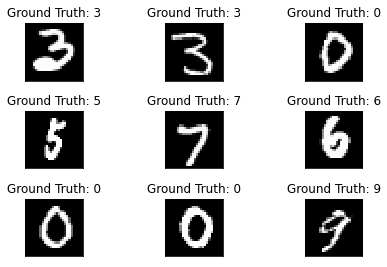

In [ ]:
import matplotlib.pyplot as plt

examples = enumerate(loaders['test'])
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])


Batch accuracy: 0.99
See 9 examples below


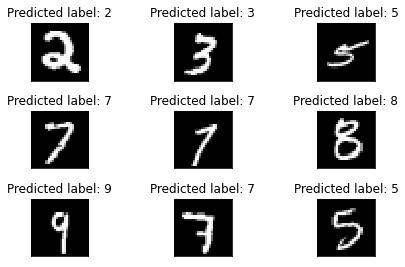

In [ ]:
# run for the first test batch
batch = 0
test_batch = 1
with torch.no_grad():
    for images, labels in loaders['test']:
      batch +=1
      out = cnn(images)
      pred_y = torch.max(out, 1)[1].data.squeeze()
      accuracy = (pred_y == labels.type(torch.LongTensor)).sum().item() / float(labels.size(0))
      # print(pred_y)
      if batch == test_batch:
        print(f'Batch accuracy: {accuracy}')
        print('See 9 examples below')
        for i in range(9):
          plt.subplot(3,3,i+1)
          plt.tight_layout()
          plt.imshow(images[i].squeeze(), cmap='gray', interpolation='none')
          plt.title("Predicted label: {}".format(pred_y[i]))
          plt.xticks([])
          plt.yticks([])
        break

In [ ]:
print(pred_labels[:6])


[1, 4, 9, 1, 9, 1]
